In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier


/mnt/c/Users/jam60/OneDrive/Repos/vivaldi/back_testing


In [2]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

def filter_optimal(optimal):
    if optimal > 0.99:
        return 1.0
    # elif optimal < -0.99:
    #     return -1.0
    else:
        return 0.0


model = Trading(load_config())

dataset_list = []
for d in model.dfs:
    print(d[1])
    cur_dataset = d[0]
    my_inds = fetchIndicators(["rsi", "macd", "stochastic_oscillator", "optimal_v2", 'slope', 'variance', 'bollinger_bands', 'ema', 'sma'], param_specification={
        'macd.signal': 360,
        'macd.ema_slow': 240,
        'macd.ema_fast': 480,
        'ema.period': 360,
        'sma.period': 360,
        'stochastic_oscillator.highlow': 360,
        'stochastic_oscillator.k': 1080,
        'rsi.period': 360,
        'bollinger_bands.period': 360
    })
    genDataForAll(cur_dataset, my_inds)
    cur_dataset.dropna(inplace=True)
    mm_scalar = MinMaxScaler()
    cur_dataset['boll_diff_upper'] = (cur_dataset['boll_upper'] - cur_dataset['close']) / cur_dataset['close']
    cur_dataset['boll_diff_lower'] = (cur_dataset['boll_lower']- cur_dataset['close']) / cur_dataset['close']
    cur_dataset['ema_diff'] = (cur_dataset['EMA'] - cur_dataset['close']) / cur_dataset['close']
    cur_dataset['sma_diff'] = (cur_dataset['SMA'] - cur_dataset['close']) / cur_dataset['close']
    
    cur_dataset[["rsi", "stosc_k", "stosc_d", "macd_diff", 'variance', 'boll_diff_lower', 'boll_diff_upper', 'ema_diff', 'sma_diff']] = mm_scalar.fit_transform(cur_dataset[["rsi", "stosc_k", "stosc_d", "macd_diff", 'variance', 'boll_diff_lower', 'boll_diff_upper', 'ema_diff', 'sma_diff']])
    cur_dataset['optimal'] = cur_dataset.apply(lambda x: filter_optimal(x.optimal), axis=1)
    dataset_list.append(cur_dataset)




XBTUSD
XRPUSD
ETHUSD
LTCUSD


In [3]:
final_dataset = pd.concat(dataset_list)

In [4]:


train, test = train_test_split(final_dataset, test_size=0.2, shuffle=False)


<h3>Models</h3>
<p>Random Forest</p>
<p>Fine tuned RF</p>
<p>Gradient boost</p>
<p>GB inside RF</p>
<p>RF inside GB</p>
<p>LSTM</p>

In [5]:

buy_signals = train[train['optimal'] == 1.0]

In [6]:
mean_num_singals = int(len(buy_signals))

In [7]:
not_signals = train[train['optimal'] == 0.0]


In [8]:
print(mean_num_singals, len(not_signals))

11183 8968406


In [107]:
not_signals_sampled = not_signals.sample(n=mean_num_singals * 16, random_state=69420, axis=0)
not_signals_sampled = not_signals_sampled.sample(frac=1)

In [108]:

balanced_data_buy = pd.concat([not_signals_sampled, buy_signals])

In [109]:
# filtered_balanced_data_buy = balanced_data_buy[["close", "stosc_k", "stosc_d", "slope", 'rsi']]
filtered_balanced_data_buy = balanced_data_buy[["rsi", "stosc_k", "stosc_d", "macd_diff", 'boll_diff_lower', 'boll_diff_upper', 'ema_diff', 'sma_diff']]




balanced_data_optimal_buy = balanced_data_buy[['optimal']]



In [110]:

clf_buy = RandomForestClassifier(random_state=69420, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=10)

clf_buy.fit(filtered_balanced_data_buy, balanced_data_optimal_buy)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=69420,
                       verbose=0, warm_start=False)

In [111]:
def insert_buys(close, prediction):
    if prediction == 1:
        return close
    else:
        return None

def insert_sells(close, prediction):
    if prediction == -1:
        return close
    else:
        return None



In [112]:
import pickle

In [113]:
filtered_test = test[["close", 'optimal']]
filtered_test_2 = test[["rsi", "stosc_k", "stosc_d", "macd_diff", 'boll_diff_lower', 'boll_diff_upper', 'ema_diff', 'sma_diff']]

In [114]:
# filtered_sell = test[["close", "rsi", "MACD", "stosc_k", "stosc_d", "slope", "variance"]]

In [115]:
# sell_model = pickle.load(open('./v2/strategy/saved_models/optimal_v2_sell_rf.sav', 'rb'))

In [116]:
filtered_test['predict_buy'] = clf_buy.predict(filtered_test_2.values)
# filtered_test['predict_sell'] = sell_model.predict(filtered_sell)

In [117]:
len(filtered_test)

2244898

In [118]:
len(filtered_test[filtered_test['predict_buy'] != 0.0])

4274

In [119]:

filtered_test['buy'] = filtered_test.apply(lambda x: insert_buys(x.close, x.predict_buy), axis=1)
filtered_test['optimal_buy'] = filtered_test.apply(lambda x: insert_buys(x.close, x.optimal), axis=1)
# filtered_test['sell'] = filtered_test.apply(lambda x: insert_sells(x.close, x.predict_sell), axis=1)



In [120]:
reset_filtered = filtered_test.reset_index(drop=True)

In [121]:
# reset_filtered

In [122]:
# reset_filtered['count'] = reset_filtered['sell'].rolling(60).count() - reset_filtered['buy'].rolling(60).count() 

In [123]:
# reset_filtered

In [138]:
first_amnt = reset_filtered[10000:11000]

<Figure size 432x288 with 0 Axes>

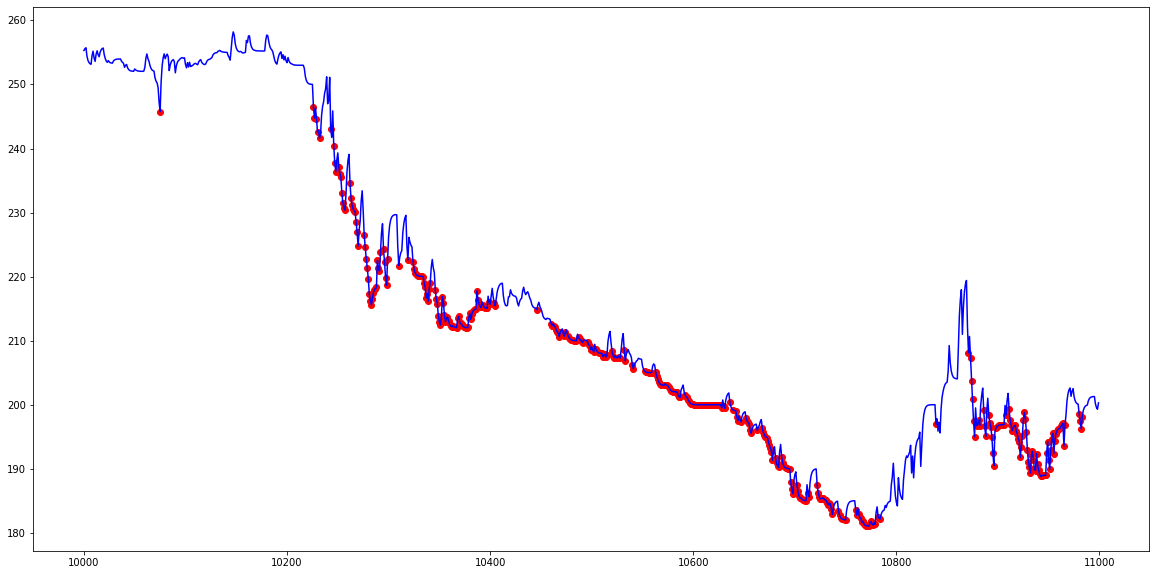

In [139]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=first_amnt.index, y=first_amnt['buy'], color='red')
# plt.scatter(x=first_amnt.index, y=first_amnt['optimal_buy'], color='purple')

# plt.scatter(x=first_amnt.index, y=first_amnt['sell'], color='green')

plt.plot(first_amnt.index, first_amnt['close'], color='blue')
plt.show()

In [140]:
# plt.figure(figsize=(20,10))
# plt.plot(first_amnt.index, first_amnt['count'].rolling(480).mean(), color='purple')
# plt.plot(first_amnt.index, first_amnt['count'].rolling(1440).mean(), color='blue')
# plt.plot(first_amnt.index, first_amnt['count'].rolling(4320).mean(), color='orange')
# plt.show()